# Install Dependencies
(Remember to choose GPU in Runtime if not already selected. Runtime -> Change Runtime type -> Hardware accelerator -> GPU)

In [1]:
# clone YOLOv5 repository
!git clone https://github.com/ultralytics/yolov5.git # clone repo
%cd yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 16517, done.
remote: Counting objects: 100% (115/115), done.
remote: Compressing objects: 100% (98/98), done.
remote: Total 16517 (delta 47), reused 55 (delta 17), pack-reused 16402
Receiving objects: 100% (16517/16517), 15.12 MiB | 22.12 MiB/s, done.
Resolving deltas: 100% (11309/11309), done.
/content/yolov5


In [2]:
%pwd

'/content/yolov5'

In [3]:
!nvidia-smi

Mon Mar 11 12:56:44 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
# install dependencies as necessary
!pip install -qr requirements.txt  # install dependencies (ignore errors)
import torch

from IPython.display import Image, clear_output  # to display images
# from utils.google_utils import gdrive_download  # to download models/datasets

# clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.0/721.0 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.2 MB/s eta 0:00:00
Setup complete. Using torch 2.1.0+cu121 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15102MB, multi_processor_count=40)


# **Your Custom Data**

In [5]:
!pwd

/content/yolov5


In [6]:
# Export code snippet and paste here
%cd /content
!curl -L "https://github.com/tejas05in/data/raw/main/sign%20language%20project.v1i.yolov5pytorch.zip" > SignData.zip; unzip SignData.zip; rm SignData.zip


/content
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  933k  100  933k    0     0  1247k      0 --:--:-- --:--:-- --:--:-- 3873k
Archive:  SignData.zip
 extracting: README.dataset.txt      
 extracting: README.roboflow.txt     
 extracting: data.yaml               
   creating: test/
   creating: test/images/
 extracting: test/images/Hello-4105856a-dd6e-11ee-ab78-d7d8e042d7b3_jpg.rf.cd7fcf632efb0f44736ea776bae578c3.jpg  
 extracting: test/images/Hello-45d9d3bc-dd6e-11ee-a842-d7d8e042d7b3_jpg.rf.1f6c56324d0e5073a4082986e4834d92.jpg  
 extracting: test/images/ILoveYou-6a1f8491-dd6e-11ee-aa03-d7d8e042d7b3_jpg.rf.b71d8cf8cf1c419ad67badfce2eb7d89.jpg  
   creating: test/labels/
 extracting: test/labels/Hello-4105856a-dd6e-11ee-ab78-d7d8e042d7b3_jpg.rf.cd7fcf632efb0f44736ea776bae578c3.txt  
 extract

In [7]:
# this is the YAML file  we're loading into this notebook with our data
%cat data.yaml

train: ../train/images
val: ../valid/images
test: ../test/images

nc: 6
names: ['Hello', 'ILoveYou', 'No', 'Please', 'Thanks', 'Yes']

roboflow:
  workspace: objectdetectionworkspace-urooa
  project: sign-language-project-opdbe
  version: 1
  license: CC BY 4.0
  url: https://universe.roboflow.com/objectdetectionworkspace-urooa/sign-language-project-opdbe/dataset/1

# **Define Model Configuration and Architecture**
We will write a yaml script that defines the parameters for our model like the number of classes, anchors, and each layer.

You do not need to edit these cells, but you may.

In [8]:
# define number of classes based on YAML
import yaml
with open("data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [9]:
num_classes

'6'

In [10]:
#this is the model configuration we will use
%cat /content/yolov5/models/yolov5s.yaml

# YOLOv5 🚀 by Ultralytics, AGPL-3.0 license

# Parameters
nc: 80 # number of classes
depth_multiple: 0.33 # model depth multiple
width_multiple: 0.50 # layer channel multiple
anchors:
  - [10, 13, 16, 30, 33, 23] # P3/8
  - [30, 61, 62, 45, 59, 119] # P4/16
  - [116, 90, 156, 198, 373, 326] # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [
    [-1, 1, Conv, [64, 6, 2, 2]], # 0-P1/2
    [-1, 1, Conv, [128, 3, 2]], # 1-P2/4
    [-1, 3, C3, [128]],
    [-1, 1, Conv, [256, 3, 2]], # 3-P3/8
    [-1, 6, C3, [256]],
    [-1, 1, Conv, [512, 3, 2]], # 5-P4/16
    [-1, 9, C3, [512]],
    [-1, 1, Conv, [1024, 3, 2]], # 7-P5/32
    [-1, 3, C3, [1024]],
    [-1, 1, SPPF, [1024, 5]], # 9
  ]

# YOLOv5 v6.0 head
head: [
    [-1, 1, Conv, [512, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, "nearest"]],
    [[-1, 6], 1, Concat, [1]], # cat backbone P4
    [-1, 3, C3, [512, False]], # 13

    [-1, 1, Conv, [256, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, "nearest"]],
    [[-1, 

In [11]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [12]:
%%writetemplate /content/yolov5/models/custom_yolov5s.yaml

# parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

# Train Custom YOLOv5 Detector
## Next, we'll fire off training!
Here, we are able to pass a number of arguments:

- img: define input image size
- batch: determine batch size
- epochs: define the number of training epochs. (Note: often, 3000+ are common here!)
- data: set the path to our yaml file
- cfg: specify our model configuration
- weights: specify a custom path to weights. (Note: you can download weights from the Ultralytics Google Drive folder)
- name: result names
- nosave: only save the final checkpoint
- cache: cache images for faster training

In [13]:
# train yolov5s on custom data for 100 epochs
# time its performance
%%time
%cd /content/yolov5/
!python train.py --img 416 --batch 16 --epochs 300 --data '../data.yaml' --cfg ./models/custom_yolov5s.yaml --weights 'yolov5s.pt' --name yolov5s_results  --cache

/content/yolov5
2024-03-11 12:57:06.378684: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-11 12:57:06.378735: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-11 12:57:06.380635: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=yolov5s.pt, cfg=./models/custom_yolov5s.yaml, data=../data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=300, batch_size=16, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data/hyps, resume_evolve=None, bucket=, cache=ram, image_weights=False, devi

# **Evaluate Custom YOLOv5 Detector Performance**
Training losses and performance metrics are saved to Tensorboard and also to a logfile defined above with the --name flag when we train. In our case, we named this yolov5s_results. (If given no name, it defaults to results.txt.) The results file is plotted as a png after training completes.

Note from Glenn: Partially completed results.txt files can be plotted with from utils.utils import plot_results; plot_results()

In [ ]:
# Start tensorboard
# Launch after you have started training
# logs save in the folder "runs"
# %load_ext tensorboard
# %tensorboard --logdir runs

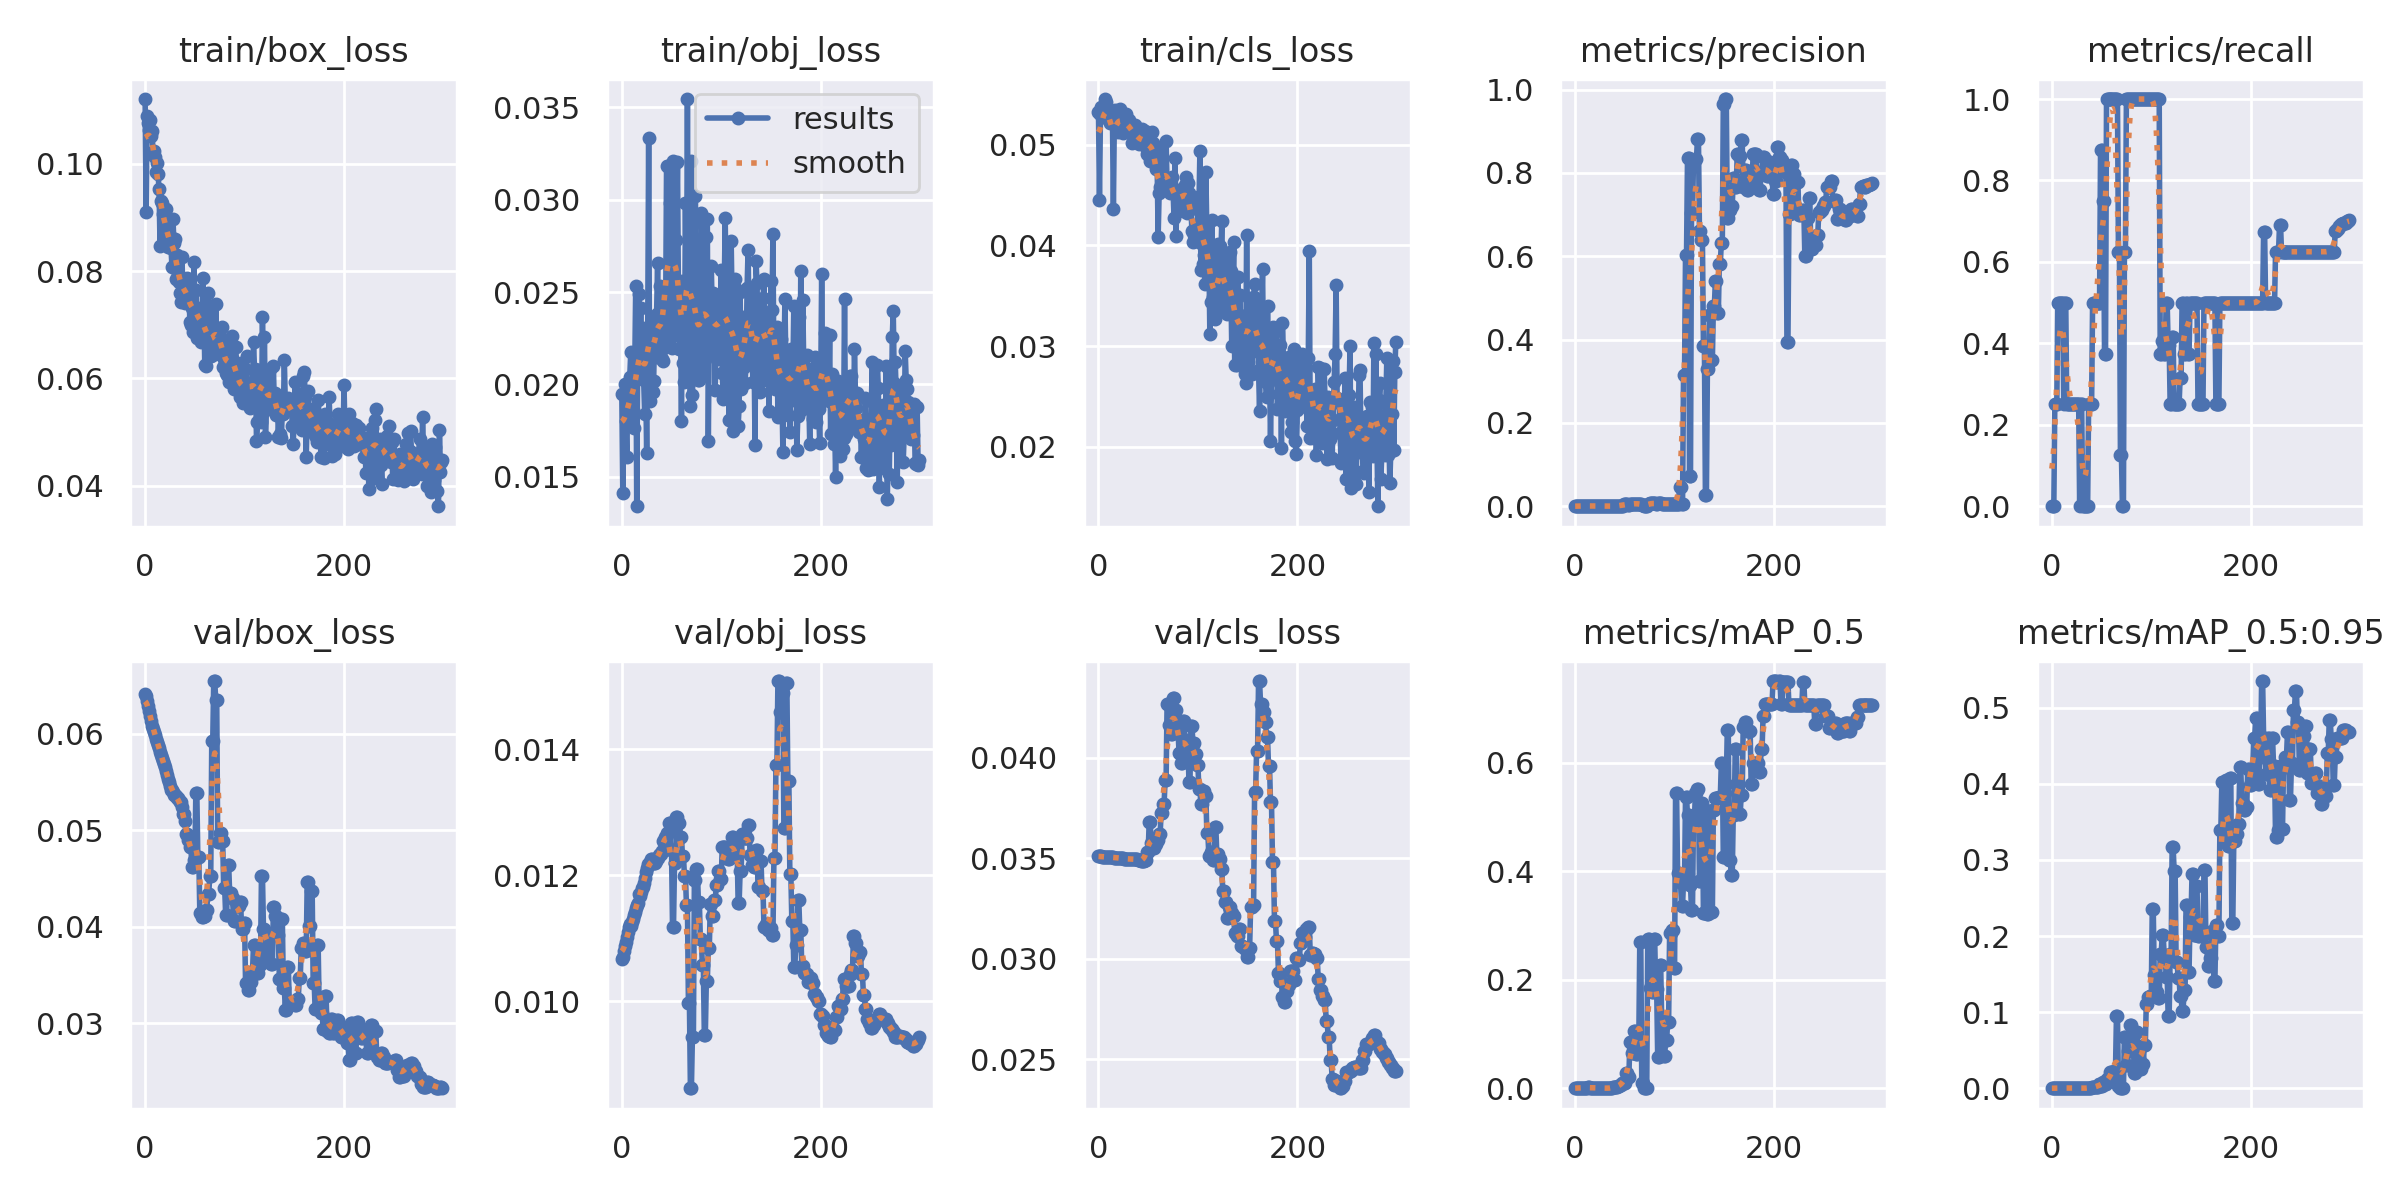

In [15]:
# we can also output some older school graphs if the tensor board isn't working for whatever reason...
from utils.plots import plot_results  # plot results.txt as results.png
Image(filename='/content/yolov5/runs/train/yolov5s_results/results.png', width=1000)  # view results.png

# **Curious? Visualize Our Training Data with Labels**
After training starts, view train*.jpg images to see training images, labels and augmentation effects.

Note a mosaic dataloader is used for training (shown below), a new dataloading concept developed by Glenn Jocher and first featured in YOLOv4.

GROUND TRUTH TRAINING DATA:


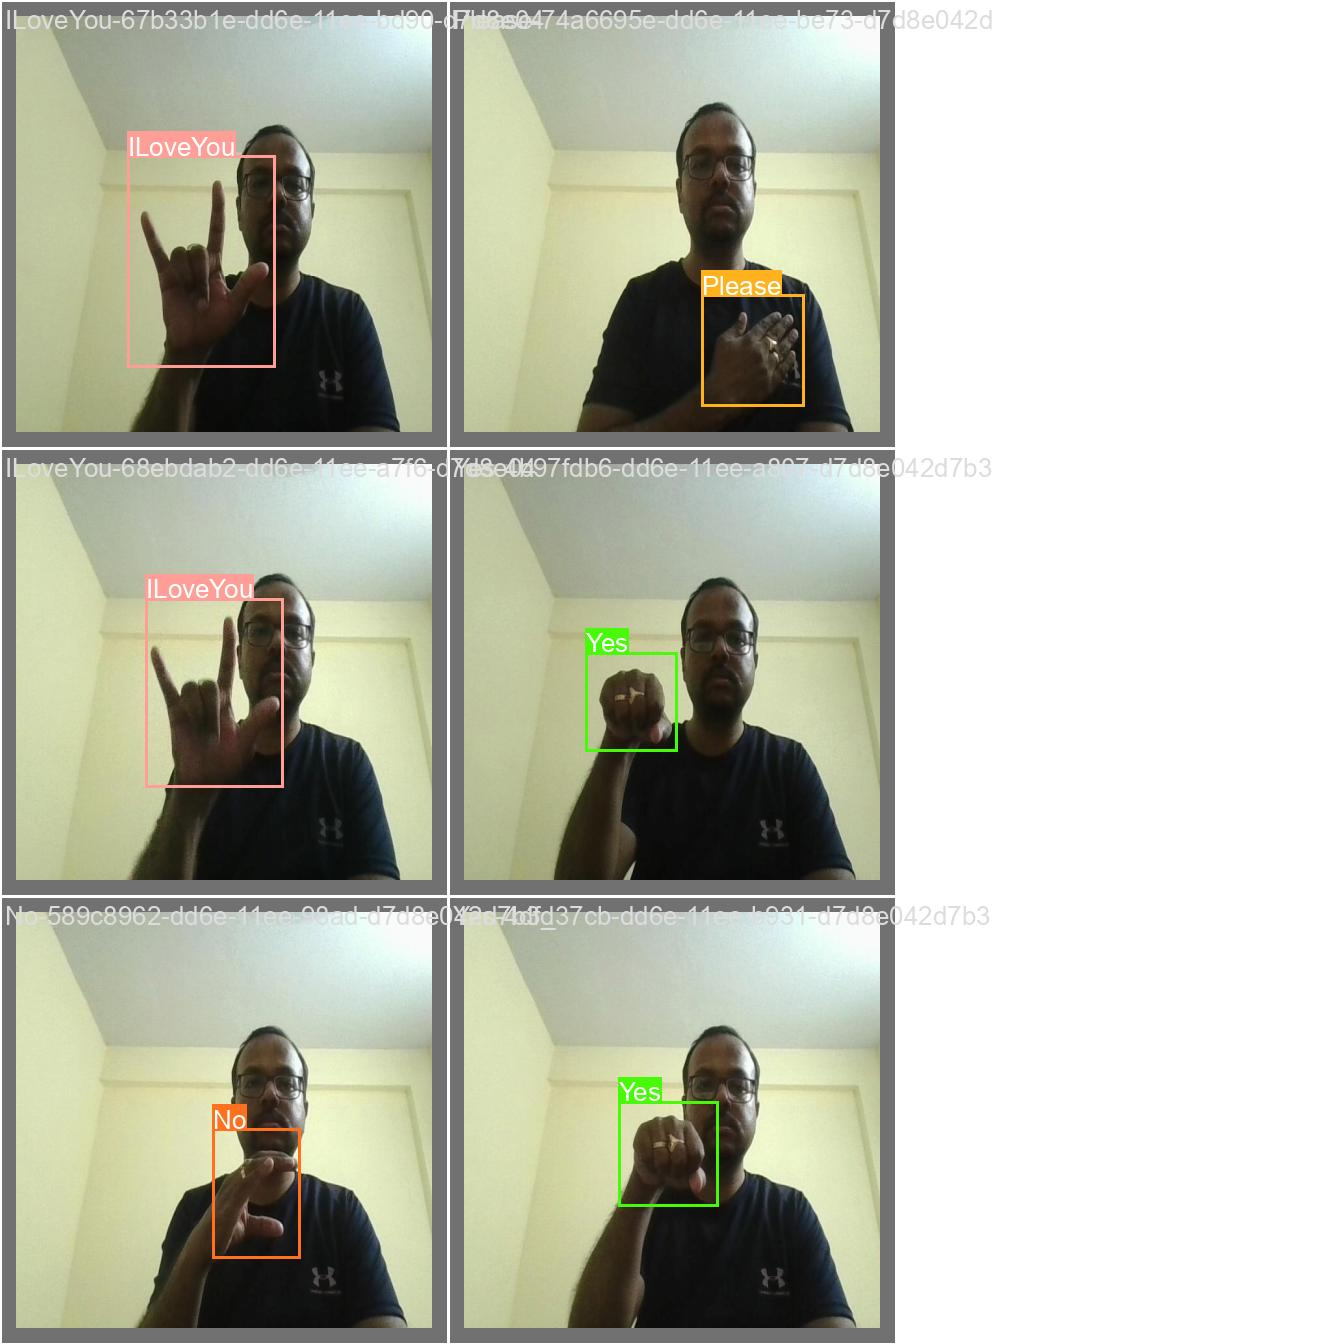

In [16]:
# first, display our ground truth data
print("GROUND TRUTH TRAINING DATA:")
Image(filename='/content/yolov5/runs/train/yolov5s_results/val_batch0_labels.jpg', width=900)

GROUND TRUTH AUGMENTED TRAINING DATA:


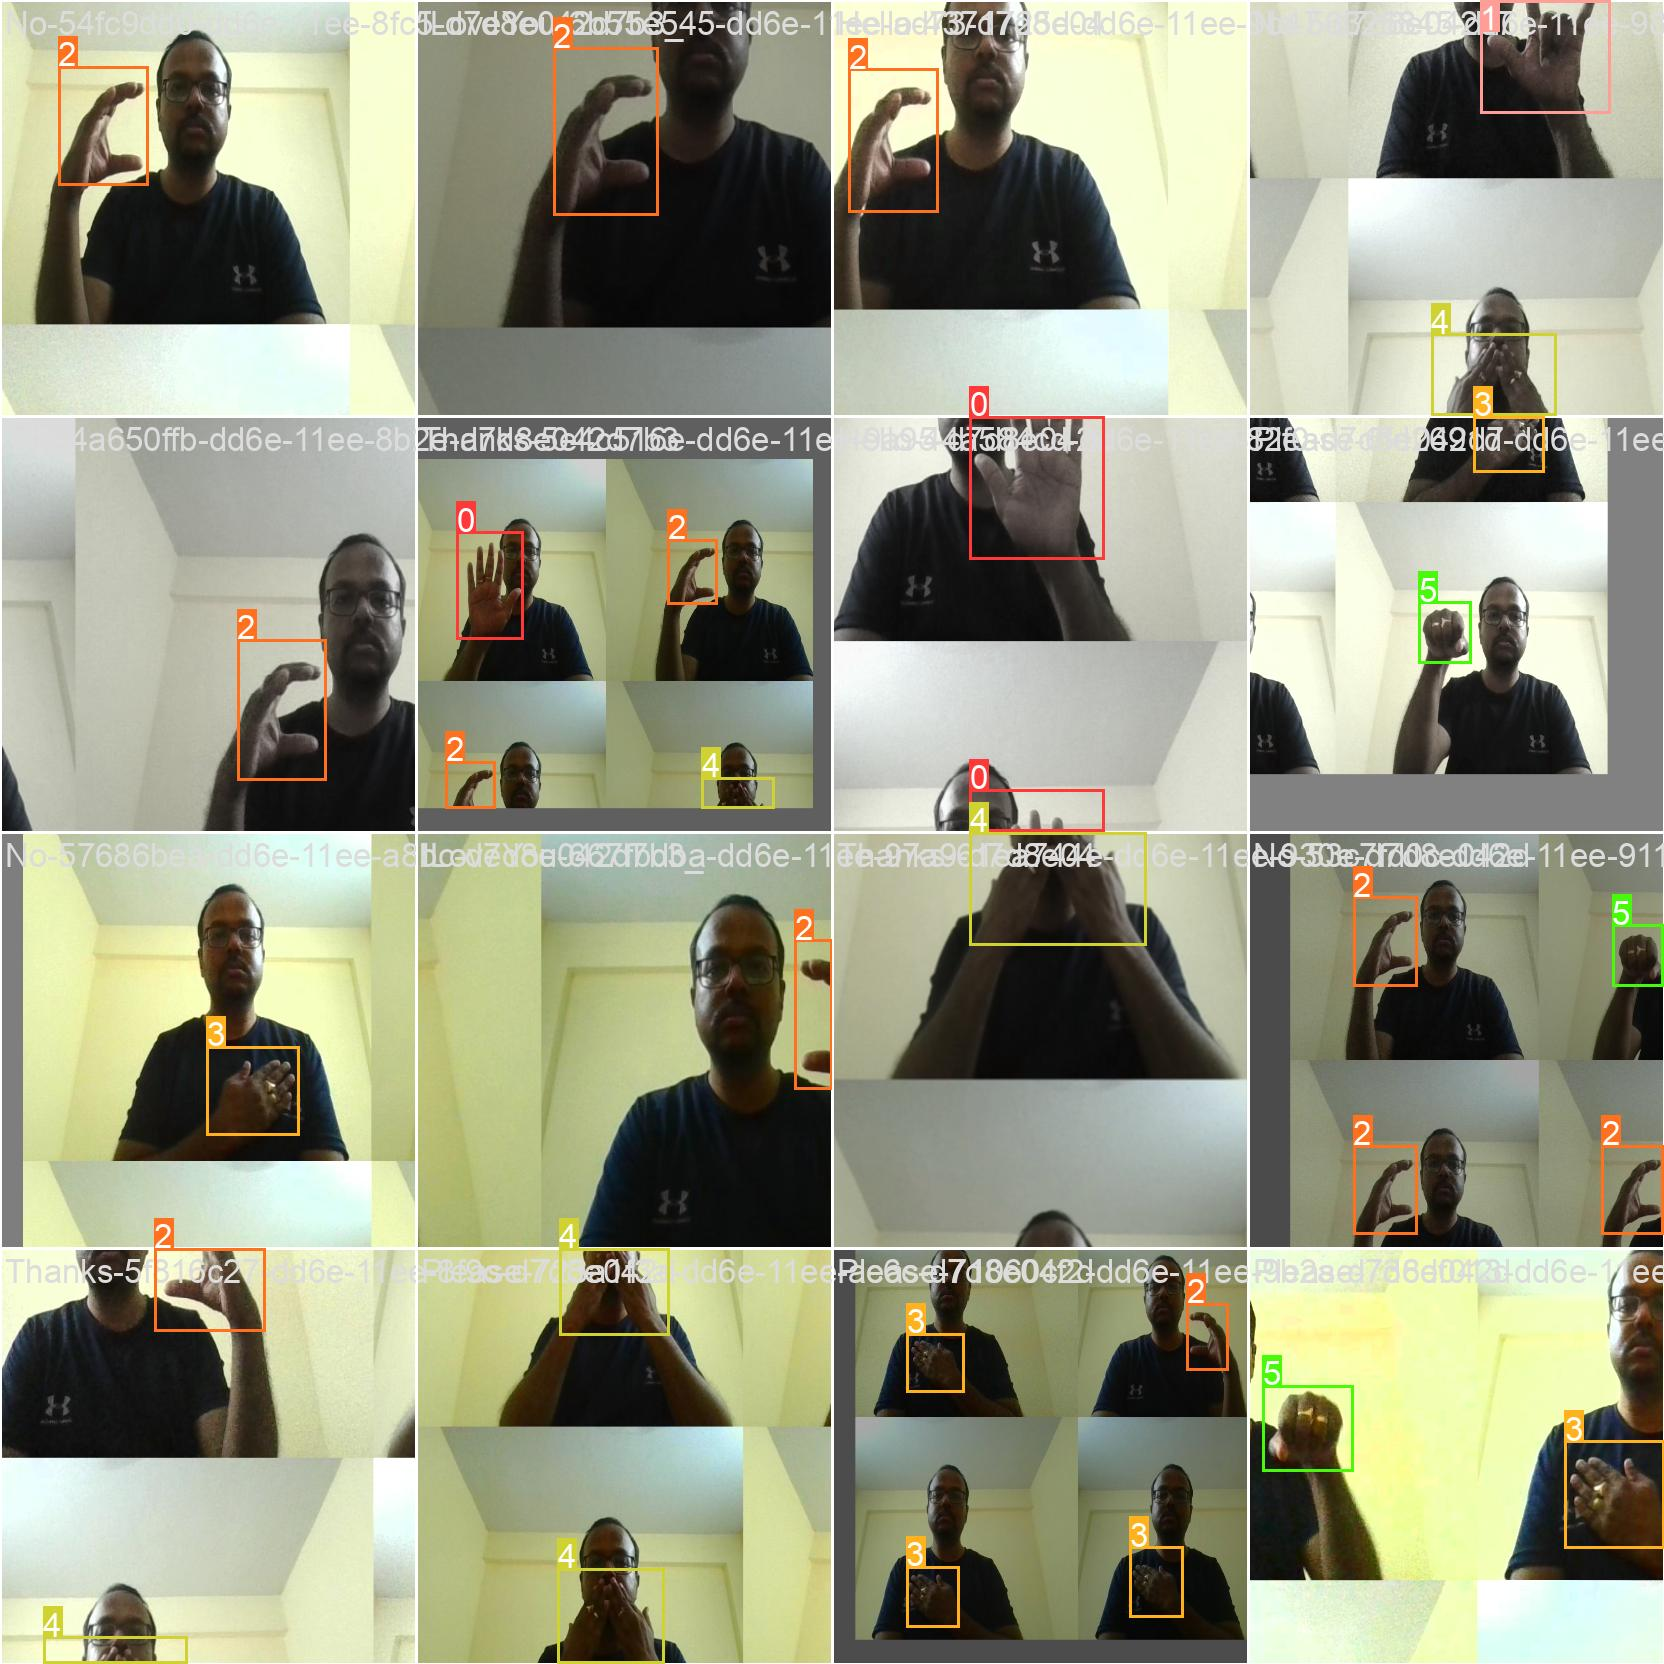

In [17]:
# print out an augmented training example
print("GROUND TRUTH AUGMENTED TRAINING DATA:")
Image(filename='/content/yolov5/runs/train/yolov5s_results/train_batch0.jpg', width=900)

# **Run Inference With Trained Weights**
Run inference with a pretrained checkpoint on contents of test/images folder downloaded from Roboflow.

In [18]:
# trained weights are saved by default in our weights folder
%ls runs/

train/


In [19]:
%ls runs/train/yolov5s_results/weights

best.pt  last.pt


In [20]:
# when we ran this, we saw .007 second inference time. That is 140 FPS on a TESLA P100!
# use the best weights!
%cd /content/yolov5/
!python detect.py --weights runs/train/yolov5s_results/weights/best.pt --img 416 --conf 0.5 --source ../test/images

/content/yolov5
detect: weights=['runs/train/yolov5s_results/weights/best.pt'], source=../test/images, data=data/coco128.yaml, imgsz=[416, 416], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-294-gdb125a20 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
custom_YOLOv5s summary: 182 layers, 7260003 parameters, 0 gradients
WARNING ⚠️ NMS time limit 0.550s exceeded
image 1/3 /content/test/images/Hello-4105856a-dd6e-11ee-ab78-d7d8e042d7b3_jpg.rf.cd7fcf632efb0f44736ea776bae578c3.jpg: 416x416 1 Hello, 7.7ms
image 2/3 /content/test/images/Hello-45d9d3bc-dd6e-11ee-a842-d7d8e042d7b3_jpg.rf.1f6c56324d0e5073a4082986e4834d92.jpg: 416x416 

In [21]:
#display inference on ALL test images
#this looks much better with longer training above

import glob
from IPython.display import Image, display

for imageName in glob.glob('/content/yolov5/runs/detect/exp*.jpg'): #assuming JPG
    display(Image(filename=imageName))
    print("\n")

# **Export Trained Weights for Future Inference**

Now that you have trained your custom detector, you can export the trained weights you have made here for inference on your device elsewhere

In [22]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [23]:
%cp /content/yolov5/runs/train/yolov5s_results/weights/best.pt /content/gdrive/MyDrive/'Colab Notebooks'/SignLanguageDetection/model_weights